In [1]:
# Ignore  the warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
import re
import os.path
import math
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import KFold
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from scipy import sparse
from sklearn.metrics import make_scorer
from sklearn.metrics import f1_score

import nltk
from wordcloud import WordCloud
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import unicodedata

from sklearn.feature_extraction.text import TfidfVectorizer

nltk.download('stopwords')
nltk.download('wordnet')

#plt.style.use('fivethirtyeight')
sns.set_style("whitegrid")
sns.set_context("talk", font_scale=0.8)

df = pd.read_csv('../data/movies_database.csv', na_values=['#EMPTY?'])
# Fix the &apos; formatting problem
df['Description'] = df['Description'].str.replace("&apos;", "'")
df['Name'] = df['Name'].str.replace("&apos;", "'")
df['Keywords'] = df['Keywords'].str.replace("&apos;", "'")


#remove nulls and duplicates
df = df.dropna(subset="Description")
df = df.drop_duplicates(subset="Description")


# one hot enconding
dummies = df["Genre(s)"].str.get_dummies(sep=",")
df = pd.concat([df, dummies], axis=1)


# Combine as colunas 'Description' e 'Keywords'
df['Combined'] = df['Description'] + ' ' + df['Keywords'].astype(str)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\carol\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\carol\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
df.drop(['Date Published','Rating','Rating Count','Content Rating','Genre(s)','Keywords'], axis=1, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5903 entries, 2 to 9782
Data columns (total 27 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Name         5903 non-null   object
 1   Description  5903 non-null   object
 2   Action       5903 non-null   int64 
 3   Adventure    5903 non-null   int64 
 4   Animation    5903 non-null   int64 
 5   Biography    5903 non-null   int64 
 6   Comedy       5903 non-null   int64 
 7   Crime        5903 non-null   int64 
 8   Documentary  5903 non-null   int64 
 9   Drama        5903 non-null   int64 
 10  Family       5903 non-null   int64 
 11  Fantasy      5903 non-null   int64 
 12  Film-Noir    5903 non-null   int64 
 13  History      5903 non-null   int64 
 14  Horror       5903 non-null   int64 
 15  Music        5903 non-null   int64 
 16  Musical      5903 non-null   int64 
 17  Mystery      5903 non-null   int64 
 18  News         5903 non-null   int64 
 19  Romance      5903 non-null 

<AxesSubplot:>

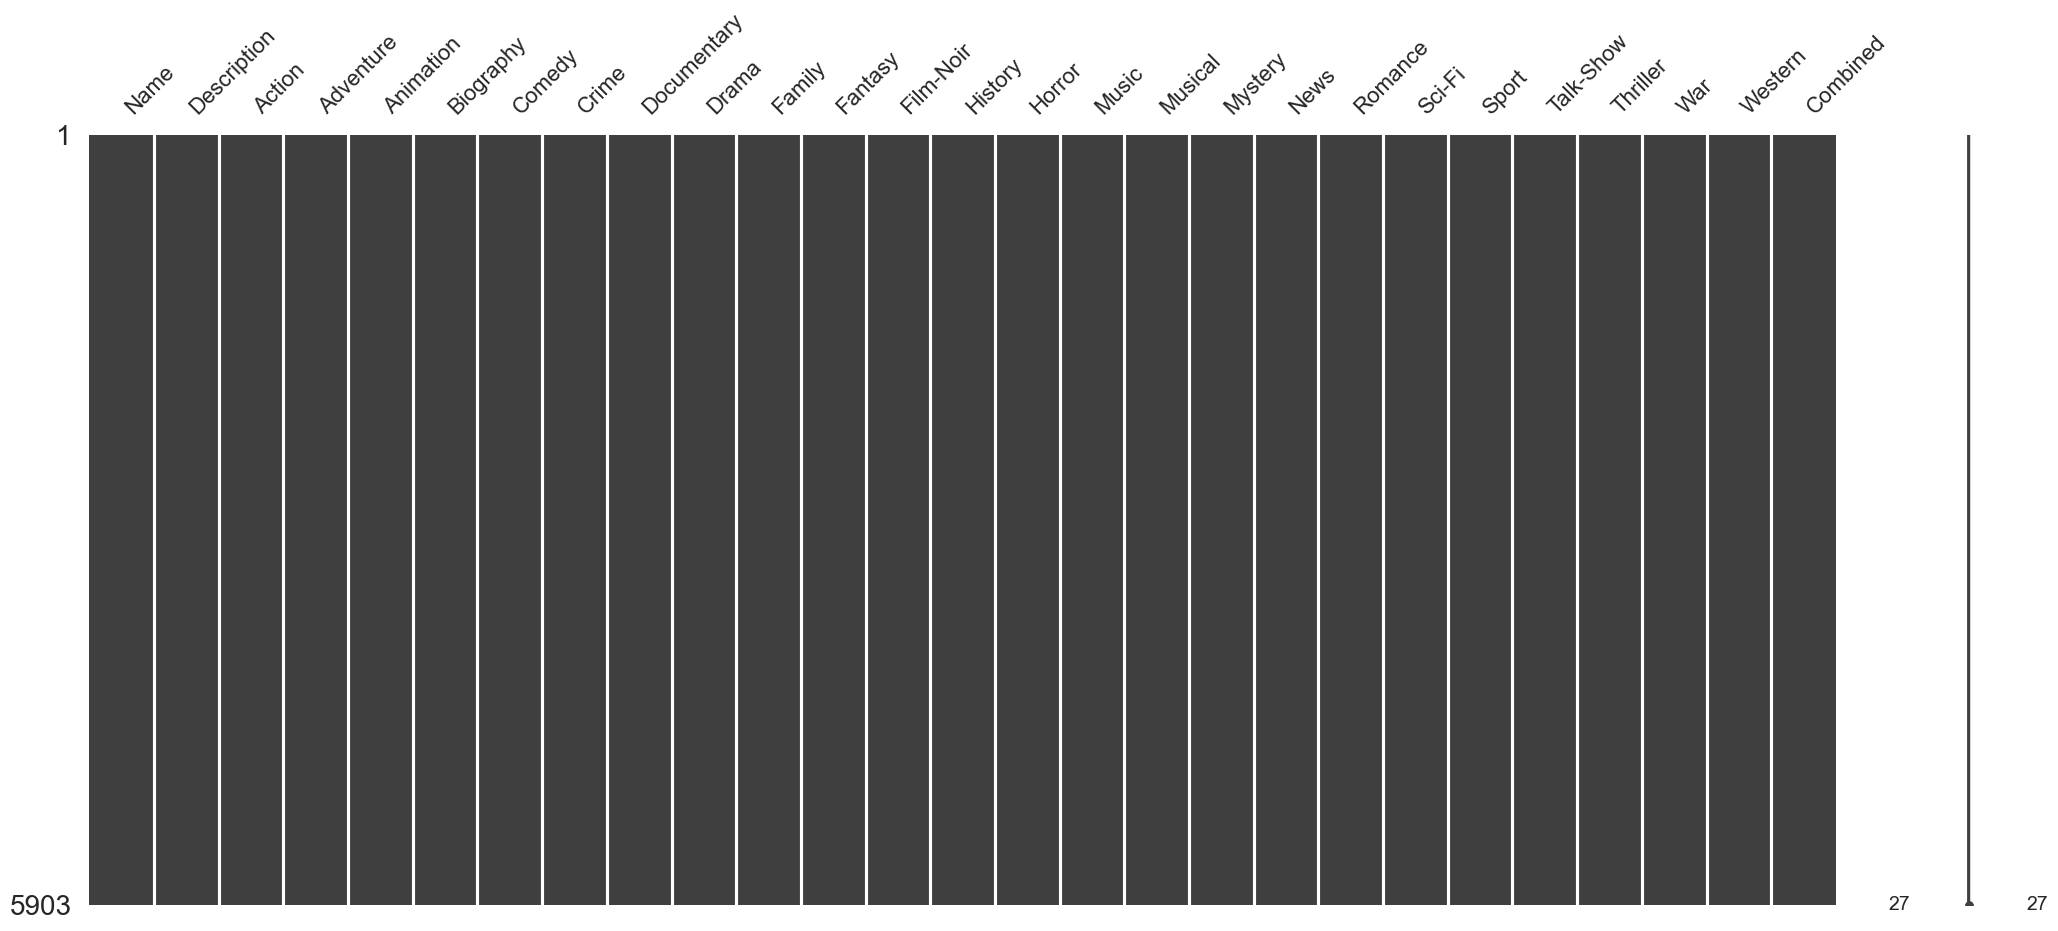

In [3]:
import missingno as msno
# identificação de dados ausentes
msno.matrix(df)

In [4]:
category_columns = df.columns.drop(['Name', 'Description', 'Combined'])

In [5]:
sum_genre = df[category_columns].astype(int).sum()
df_movies_per_genre = pd.DataFrame({'Genre':category_columns, 'Total': sum_genre})

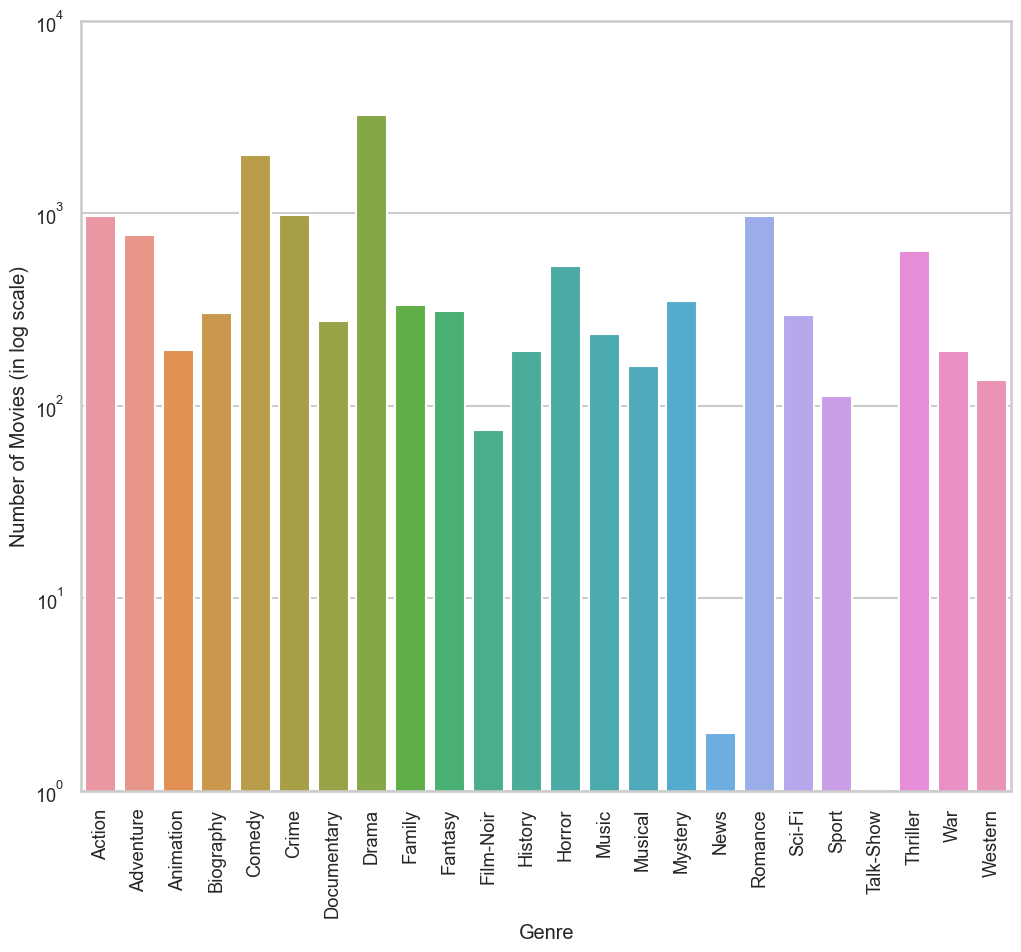

In [6]:
f, ax = plt.subplots(1, 1, figsize=(12, 10))
sns.barplot(data=df_movies_per_genre, x='Genre', y='Total', axes=ax)
ax.set(yscale='log', ylim=(1, 1e4), ylabel='Number of Movies (in log scale)')
plt.xticks(rotation=90)
plt.show()

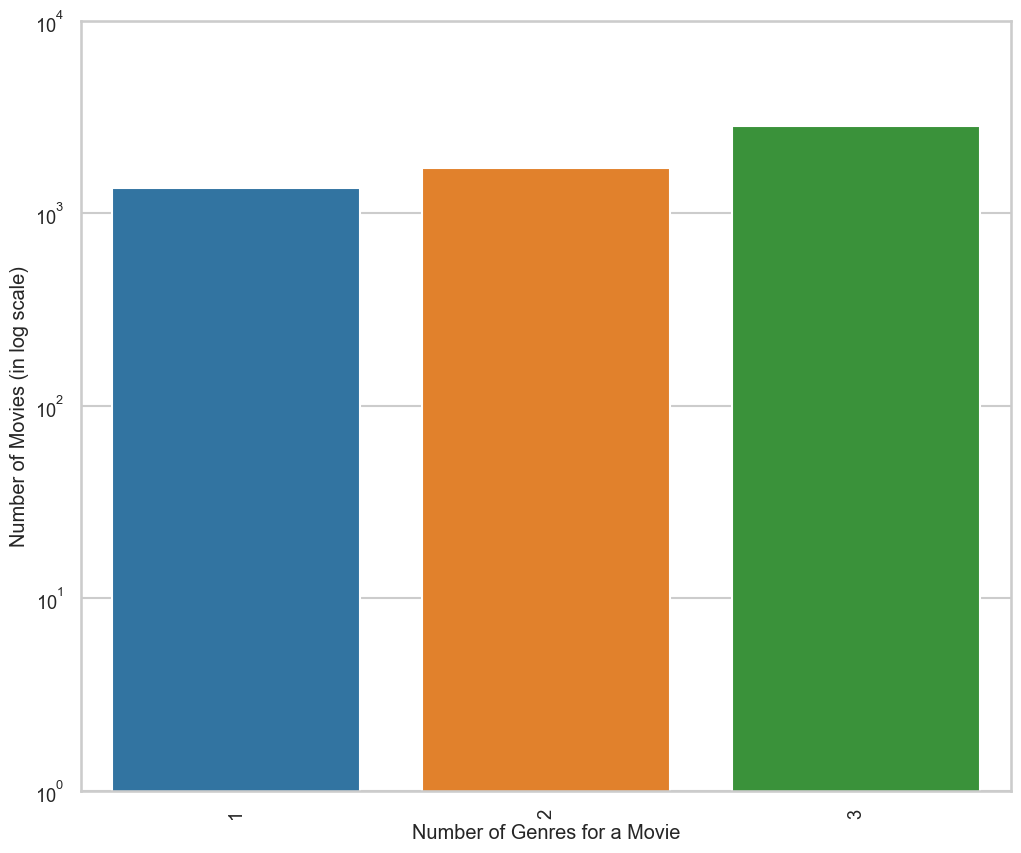

In [7]:
sum_movie = df[category_columns].sum(axis=1)
df_genres_per_movie = pd.DataFrame({'title': df.Name, 'num_genres':sum_movie}).groupby('num_genres').count()
f, ax = plt.subplots(1, 1, figsize=(12, 10))
sns.barplot(data=df_genres_per_movie, x=df_genres_per_movie.index, y='title', axes=ax)
ax.set(yscale='log', ylim=(1, 1e4), xlabel='Number of Genres for a Movie', ylabel='Number of Movies (in log scale)')
plt.xticks(rotation=90)
plt.show()

In [8]:
print('On an average, movies are classified into {0:.2f} genres'.format(sum_movie.mean()))
print('Number of movies with 3 genres = {0}'.format(len(sum_movie[sum_movie==3])))

On an average, movies are classified into 2.25 genres
Number of movies with 3 genres = 2831


In [9]:
df[category_columns].astype(int).sum()


Action          970
Adventure       771
Animation       195
Biography       304
Comedy         2002
Crime           978
Documentary     274
Drama          3255
Family          332
Fantasy         312
Film-Noir        75
History         192
Horror          529
Music           235
Musical         160
Mystery         351
News              2
Romance         967
Sci-Fi          295
Sport           112
Talk-Show         1
Thriller        639
War             193
Western         136
dtype: int64

In [10]:
# remove movies with insignificant representation data -  Film-Noir, News, Reality TV, Talk Show,Sport
genres_to_remove = ['Film-Noir', 'News', 'Talk-Show','Sport'];
entries_to_remove = df.loc[(df[genres_to_remove] == 1).any(axis=1)]

df = df.drop(entries_to_remove.index, axis=0)
df.drop(genres_to_remove, axis=1, inplace=True)

In [11]:
category_columns = category_columns.drop(['Film-Noir', 'News', 'Talk-Show','Sport'])
df[category_columns].astype(int).sum()


Action          965
Adventure       768
Animation       195
Biography       287
Comedy         1961
Crime           910
Documentary     260
Drama          3126
Family          323
Fantasy         311
History         191
Horror          529
Music           232
Musical         157
Mystery         338
Romance         956
Sci-Fi          295
Thriller        631
War             193
Western         136
dtype: int64

In [12]:
df['Name'].count()

5713

In [20]:
def remove_accents(sentence):
    cleaned_sentence = unicodedata.normalize('NFD', sentence)
    cleaned_sentence = cleaned_sentence.encode('ascii', 'ignore')
    cleaned_sentence = cleaned_sentence.decode("utf-8")
    return cleaned_sentence

def remove_punctuation(sentence):
    cleaned_sentence = re.sub(r'[?|!|\'|"|#]', '', sentence)
    cleaned_sentence = re.sub(r'[,|.|;|:|(|)|{|}|\|/|<|>]|-', ' ', cleaned_sentence)
    cleaned_sentence = cleaned_sentence.replace("\n"," ")
    return cleaned_sentence

def keep_alpha(sentence):
    alpha_sentence = re.sub('[^a-z A-Z]+', ' ', sentence)
    return alpha_sentence

def stemming(sentence):
    stemmer = SnowballStemmer("english")
    stemmed_words = [stemmer.stem(word) for word in sentence.split()]
    stemmed_sentence=' '.join(stemmed_words)
    return stemmed_sentence

def lemmatize_words(sentence):
    lem = WordNetLemmatizer()
    lemmatized_words = [lem.lemmatize(word, 'v') for word in sentence.split()]
    lemmatized_sentence=' '.join(lemmatized_words)
    return lemmatized_sentence

def remove_stop_words(sentence):
    stop_words = set(stopwords.words('english'))
    stop_words.update(['zero','one','two','three','four','five','six','seven','eight','nine','ten',
                       'may','also','across','among','beside','however','yet','within','apos'])
    no_stop_words=[word for word in sentence.split() if word not in stop_words]
    no_step_sentence = ' '.join(no_stop_words)
    return no_step_sentence

def text_preprocess(sentence):
    pre_processed_sentence = remove_accents(sentence)
    pre_processed_sentence = remove_punctuation(pre_processed_sentence)
    pre_processed_sentence = keep_alpha(pre_processed_sentence)
    pre_processed_sentence = lower_case(pre_processed_sentence)
    #pre_processed_sentence = stemming(pre_processed_sentence) # Use Lemmatize instead of stemming
    pre_processed_sentence = lemmatize_words(pre_processed_sentence)
    pre_processed_sentence = remove_stop_words(pre_processed_sentence)
    
    return pre_processed_sentence

def lower_case(sentence):
    lower_case_sentence = sentence.lower()
    return lower_case_sentence

df['Combined'] = df['Combined'].apply(text_preprocess)
df.to_csv('../data/movies_genres_preprocessed.csv', index=False)


In [22]:
##word cloud
def save_wordcloud_plots(data, labels):
    for idx, col in enumerate(labels):
        wordcloud = WordCloud(max_font_size=50).generate(' '.join(data[data[col]==1]['Combined']))
        ax = plt.figure(figsize=(9, 9)).add_subplot(1, 1, 1)
        ax.imshow(wordcloud)
        ax.axis("off")
        ax.set(title='Movie Genre: {0}'.format(col))
        plt.savefig('../images/results/wordcloud_{0}.png'.format(col), bbox_inches='tight')
        plt.close()
        
def save_wordcloud_subplots(data, labels):
    num_plot = 3
    fig_per_plot = math.ceil(len(category_columns)/num_plot)
    num_cols = 2
    num_rows = math.ceil(fig_per_plot/num_cols)
    for idx, col in enumerate(category_columns):
        if idx%fig_per_plot==0:
            fig = plt.figure(figsize=(14, 20))
        wordcloud = WordCloud(max_font_size=50).generate(' '.join(df[df[col]==1]['Combined']))
        ax = fig.add_subplot(num_rows, num_cols, idx%fig_per_plot+1)
        ax.imshow(wordcloud)
        ax.axis("off")
        ax.set(title='Movie Genre: {0}'.format(col))
        if (idx+1)%fig_per_plot==0 or idx==len(category_columns)-1:
            plt.savefig('../images/results/wordcloud_part{0}.png'.format(1+idx//fig_per_plot), bbox_inches='tight')
            plt.close()
            fig = plt.figure(figsize=(14, 20))

In [23]:
if not os.path.exists('images/results/wordcloud_Action.png'):
    save_wordcloud_plots(df, category_columns)
if not os.path.exists('images/results/wordcloud_part1.png'):
    save_wordcloud_subplots(df, category_columns)

<Figure size 1400x2000 with 0 Axes>

<Figure size 1400x2000 with 0 Axes>

<Figure size 1400x2000 with 0 Axes>

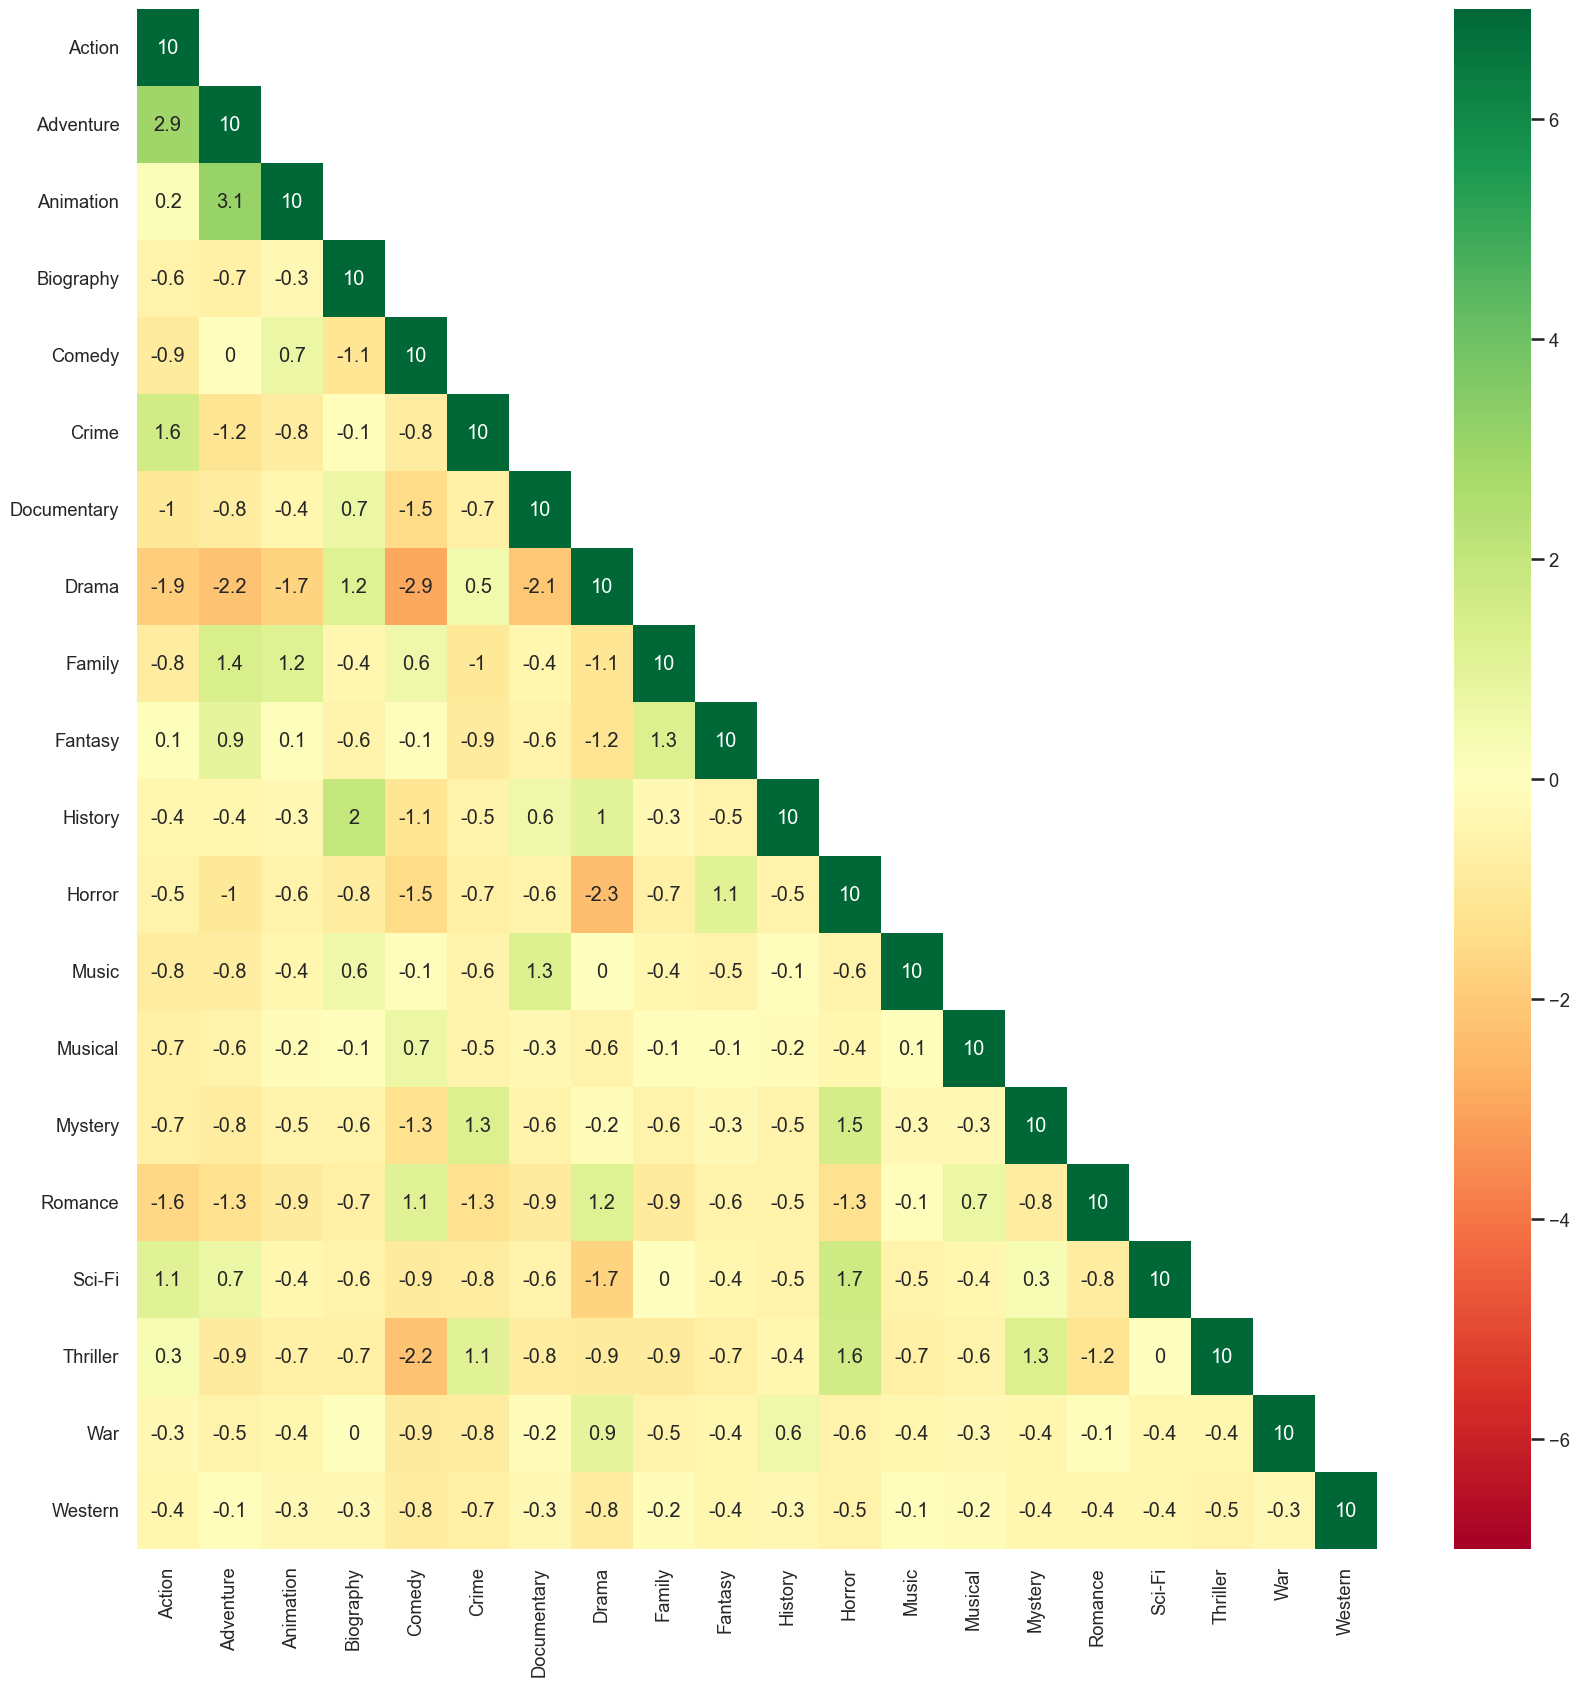

In [24]:
# Heatmap relative to all numeric columns
corr_matrix = (df[category_columns].astype('int')).corr()
mask = np.array(corr_matrix)
mask[np.tril_indices_from(mask)] = False
corr_matrix = (100*corr_matrix//1)/10

fig = plt.figure(figsize=(20, 20))
sns.heatmap(corr_matrix, mask=mask, annot=True, cbar=True, vmax=7, vmin=-7, cmap='RdYlGn')
plt.show()

In [25]:
def save_genre_pdf_given_genre_plots(data, labels):
    for idx, col in enumerate(labels):
        df_sum_given_genre = pd.DataFrame({'Genre':labels, 'Total': data[data[col]==1][labels].sum()})
        df_sum_given_genre = df_sum_given_genre.sort_values('Total', ascending=False).head(10)
        df_sum_given_genre['Total'] = df_sum_given_genre['Total']/df_sum_given_genre['Total'].max()
        ax = plt.figure(figsize=(9, 9)).add_subplot(1, 1, 1)
        sns.barplot(data=df_sum_given_genre, x='Genre', y='Total', axes=ax)
        ax.set(title='Distribution given {0} Genre'.format(col), xlabel='', ylabel='Normalized Number of Movies')
        plt.xticks(rotation=90)
        plt.savefig('../images/results/genre_pdf_given_{0}.png'.format(col), bbox_inches='tight')
        plt.close()
        
def save_genre_pdf_given_genre_subplots(data, labels):
    num_plot = 3
    fig_per_plot = math.ceil(len(category_columns)/num_plot)
    num_cols = 3
    num_rows = math.ceil(fig_per_plot/num_cols)
    for idx, col in enumerate(category_columns):
        if idx%fig_per_plot==0:
            fig = plt.figure(figsize=(20, 30))
        df_sum_given_genre = pd.DataFrame({'Genre':labels, 'Total': data[data[col]==1][labels].sum()})
        df_sum_given_genre = df_sum_given_genre.sort_values('Total', ascending=False).head(10)
        df_sum_given_genre['Total'] = df_sum_given_genre['Total']/df_sum_given_genre['Total'].max()
        ax = fig.add_subplot(num_rows, num_cols, idx%fig_per_plot+1)
        sns.barplot(data=df_sum_given_genre, x='Genre', y='Total', axes=ax)
        ax.set(title='Distribution given {0} Genre'.format(col), xlabel='', ylabel='Normalized Number of Movies')
        plt.xticks(rotation=90)
        if (idx+1)%fig_per_plot==0 or idx==len(category_columns)-1:
            plt.savefig('../images/results/genre_pdf_part{0}.png'.format(1+idx//fig_per_plot), bbox_inches='tight')
            plt.close()
            fig = plt.figure(figsize=(20, 30))

In [26]:
save_genre_pdf_given_genre_plots(df, category_columns)
save_genre_pdf_given_genre_subplots(df, category_columns)

<Figure size 2000x3000 with 0 Axes>

<Figure size 2000x3000 with 0 Axes>

<Figure size 2000x3000 with 0 Axes>

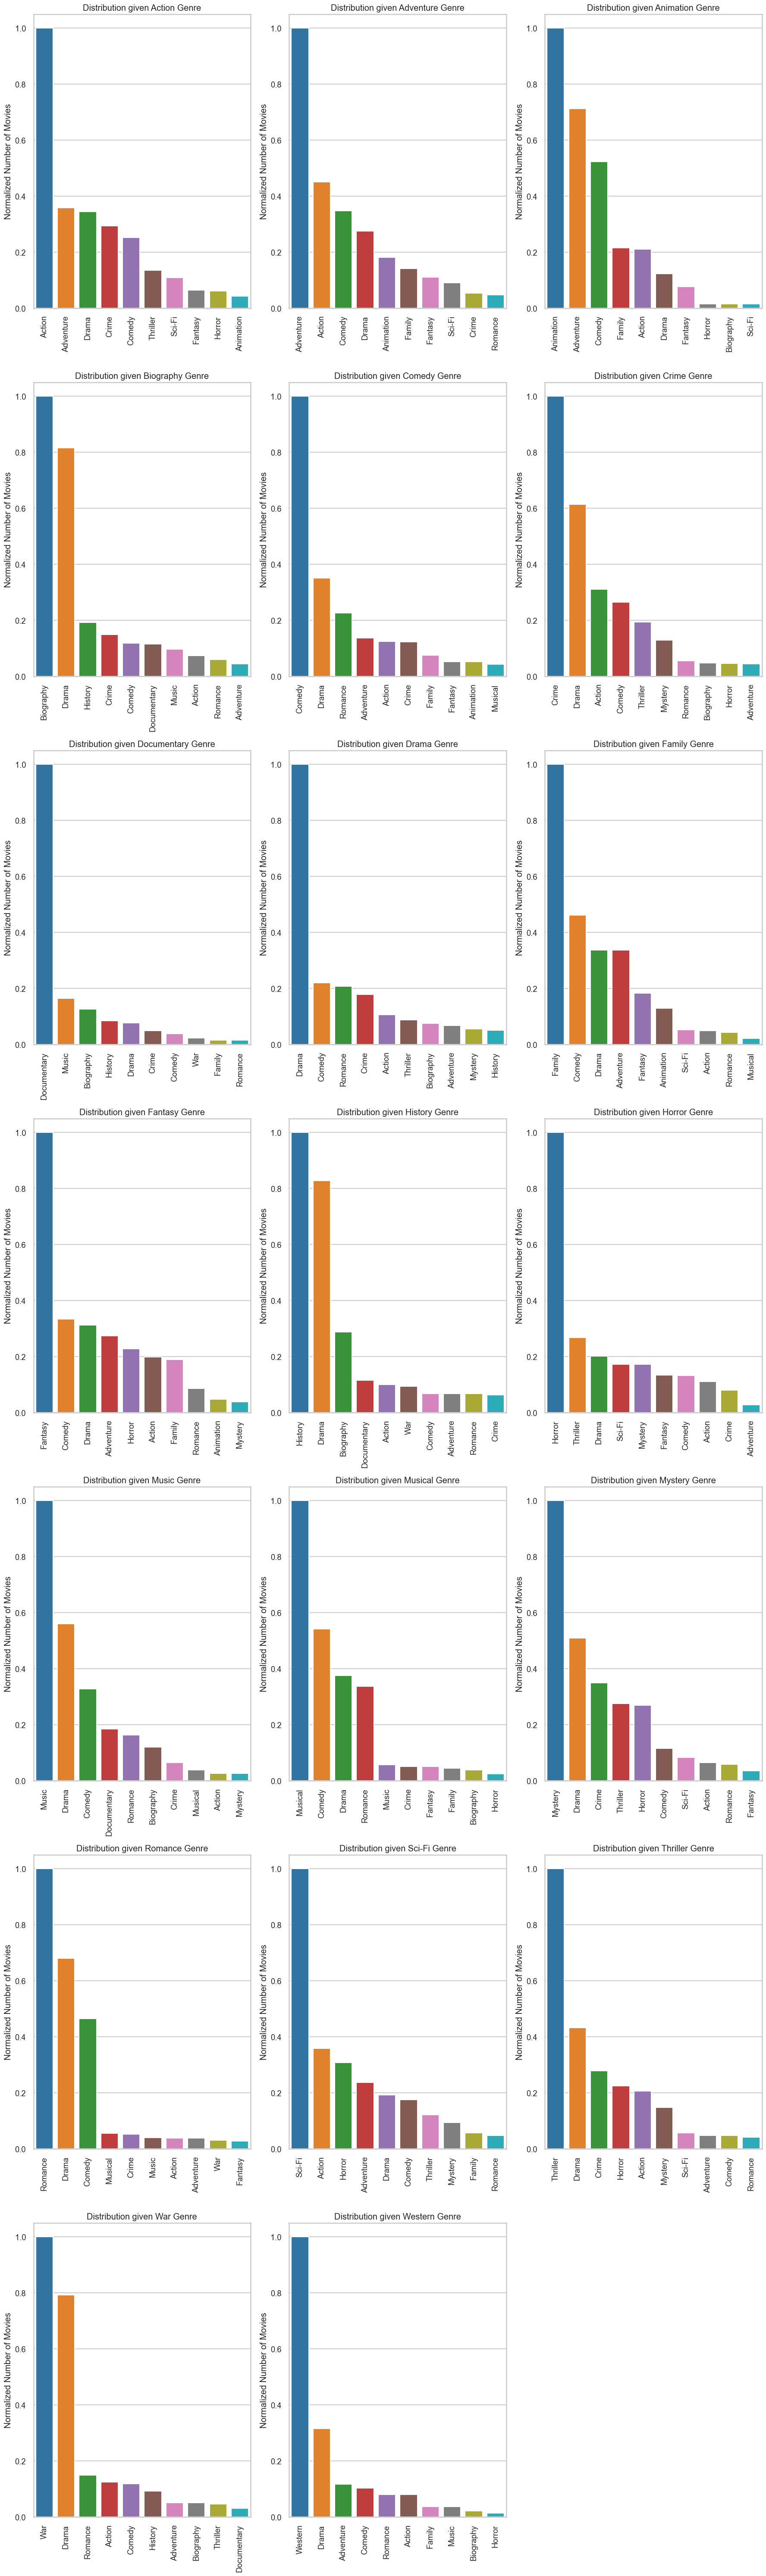

In [27]:
fig = plt.figure(figsize=(18, 60))
num_cols = 3
num_rows = math.ceil(len(category_columns)/num_cols)
for idx, col in enumerate(category_columns):
    df_sum_given_genre = pd.DataFrame({'Genre':category_columns, 'Total': df[df[col]==1][category_columns].sum()})
    df_sum_given_genre = df_sum_given_genre.sort_values('Total', ascending=False).head(10)
    df_sum_given_genre['Total'] = df_sum_given_genre['Total']/df_sum_given_genre['Total'].max()
    ax = fig.add_subplot(num_rows, num_cols, idx+1)
    sns.barplot(data=df_sum_given_genre, x='Genre', y='Total', axes=ax)
    ax.set(title='Distribution given {0} Genre'.format(col), xlabel='', ylabel='Normalized Number of Movies')
    plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

In [29]:
# Grouping genders to bigger categories to better distribute the data

dfGroupedGenders = df.copy();

dfGroupedGenders['Action and Adventure'] = dfGroupedGenders[['Action', 'Adventure', 'War', 'Western']].max(axis=1)
dfGroupedGenders['Documentary and History'] = dfGroupedGenders[['Documentary', 'History', 'Biography']].max(axis=1)
dfGroupedGenders['Family and Animation'] = dfGroupedGenders[['Family', 'Animation']].max(axis=1)
dfGroupedGenders['Fantasy and Sci-Fi'] = dfGroupedGenders[['Fantasy', 'Sci-Fi']].max(axis=1)
dfGroupedGenders['Musical'] = df[['Music', 'Musical']].max(axis=1)
dfGroupedGenders['Horror and Thriller'] = dfGroupedGenders[['Horror', 'Thriller', 'Mystery']].max(axis=1)


dfGroupedGenders = dfGroupedGenders.drop(columns=['Adventure', 'War', 'Western','Action','Documentary', 'History', 'Biography','Family', 'Animation', 'Fantasy', 'Sci-Fi', 'Music', 'Musical', 'Horror', 'Thriller', 'Mystery'])

coluna = 'Combined'

novas_colunas = [col for col in dfGroupedGenders.columns if col != coluna] + [coluna]

dfGroupedGenders = dfGroupedGenders[novas_colunas]

pd.set_option("display.max_columns", None)

category_columns_grouped = dfGroupedGenders.columns.drop(['Name', 'Description', 'Combined'])
dfGroupedGenders.head(5)

,Name,Description,Comedy,Crime,Drama,Romance,Action and Adventure,Documentary and History,Family and Animation,Fantasy and Sci-Fi,Horror and Thriller,Combined
2,The Blue Lagoon,"In the Victorian period, two children are ship...",0,0,1,0,0,0,0,0,0,victorian period children shipwreck tropical i...
6,The Best of the Blues Brothers,Dan Aykroyd and friends tell the story of the ...,0,0,0,0,0,1,0,0,0,dan aykroyd friends tell story famous saturday...
7,The Gods Must Be Crazy,A comic allegory about a traveling Bushman who...,1,0,0,0,1,0,0,0,0,comic allegory travel bushman encounter modern...
8,Star Wars: Episode IX - The Rise of Skywalker,In the riveting conclusion of the landmark Sky...,0,0,0,0,1,0,0,1,0,rivet conclusion landmark skywalker saga new l...
9,National Lampoon's Animal House,"At a 1962 college, Dean Vernon Wormer is deter...",1,0,0,0,0,0,0,0,0,college dean vernon wormer determine expel ent...


In [30]:
dfGroupedGenders.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5713 entries, 2 to 9782
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Name                     5713 non-null   object
 1   Description              5713 non-null   object
 2   Comedy                   5713 non-null   int64 
 3   Crime                    5713 non-null   int64 
 4   Drama                    5713 non-null   int64 
 5   Romance                  5713 non-null   int64 
 6   Action and Adventure     5713 non-null   int64 
 7   Documentary and History  5713 non-null   int64 
 8   Family and Animation     5713 non-null   int64 
 9   Fantasy and Sci-Fi       5713 non-null   int64 
 10  Horror and Thriller      5713 non-null   int64 
 11  Combined                 5713 non-null   object
dtypes: int64(9), object(3)
memory usage: 580.2+ KB


In [31]:
dfGroupedGenders[category_columns_grouped].sum()

Comedy                     1961
Crime                       910
Drama                      3126
Romance                     956
Action and Adventure       1660
Documentary and History     637
Family and Animation        476
Fantasy and Sci-Fi          600
Horror and Thriller        1204
dtype: int64

In [50]:
## test train split
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
import numpy as np
import pandas as pd
import math

def multi_label_train_test_split(data, labels, test_size=0.15, n_splits=10, random_state=29):
    best_train = None
    best_test = None
    best_ratio = 0

    for _ in range(n_splits):
        data_train = data.copy()
        data_test = pd.DataFrame(columns=data.columns)

        for col in labels:
            # Extracting the current genre plots
            data_curr_genre = data_train[data_train[col] == 1]

            # Split the current genre data
            curr_train, curr_test = train_test_split(data_curr_genre, test_size=test_size, random_state=random_state)

            # Update data_train and data_test
            data_train = data_train.drop(curr_test.index)
            data_test = pd.concat([data_test, curr_test])

        data_train = data_train.reset_index(drop=True)
        data_test = data_test.reset_index(drop=True)
        ratio = len(data_train) / len(data)

        if abs(ratio - (1 - test_size)) < abs(best_ratio - (1 - test_size)):
            best_train = data_train
            best_test = data_test
            best_ratio = ratio

    return best_train, best_test

In [54]:
mydata_raw = pd.read_csv('../data/movies_genres_preprocessed.csv')
min_test_size = 0.120
mydata_train, mydata_test = multi_label_train_test_split(mydata_raw, category_columns, test_size=min_test_size)

In [55]:
print('Fraction of data in the Training Data Set: {0:.3f}'.format(mydata_test.shape[0]/df.shape[0]))

Fraction of data in the Training Data Set: 0.247


In [56]:
sum_genre = df[category_columns].astype(int).sum()
sum_genre_train = mydata_train[category_columns].astype(int).sum()
sum_genre_test = mydata_test[category_columns].astype(int).sum()
df_movies_per_genre_1 = pd.DataFrame({'Genre':category_columns, 'Total': sum_genre_train/sum_genre, 'Data Set': 'Train'})
df_movies_per_genre_2 = pd.DataFrame({'Genre':category_columns, 'Total': sum_genre_test/sum_genre, 'Data Set': 'Test'})
df_movies_per_genre = pd.concat([df_movies_per_genre_1, df_movies_per_genre_2])

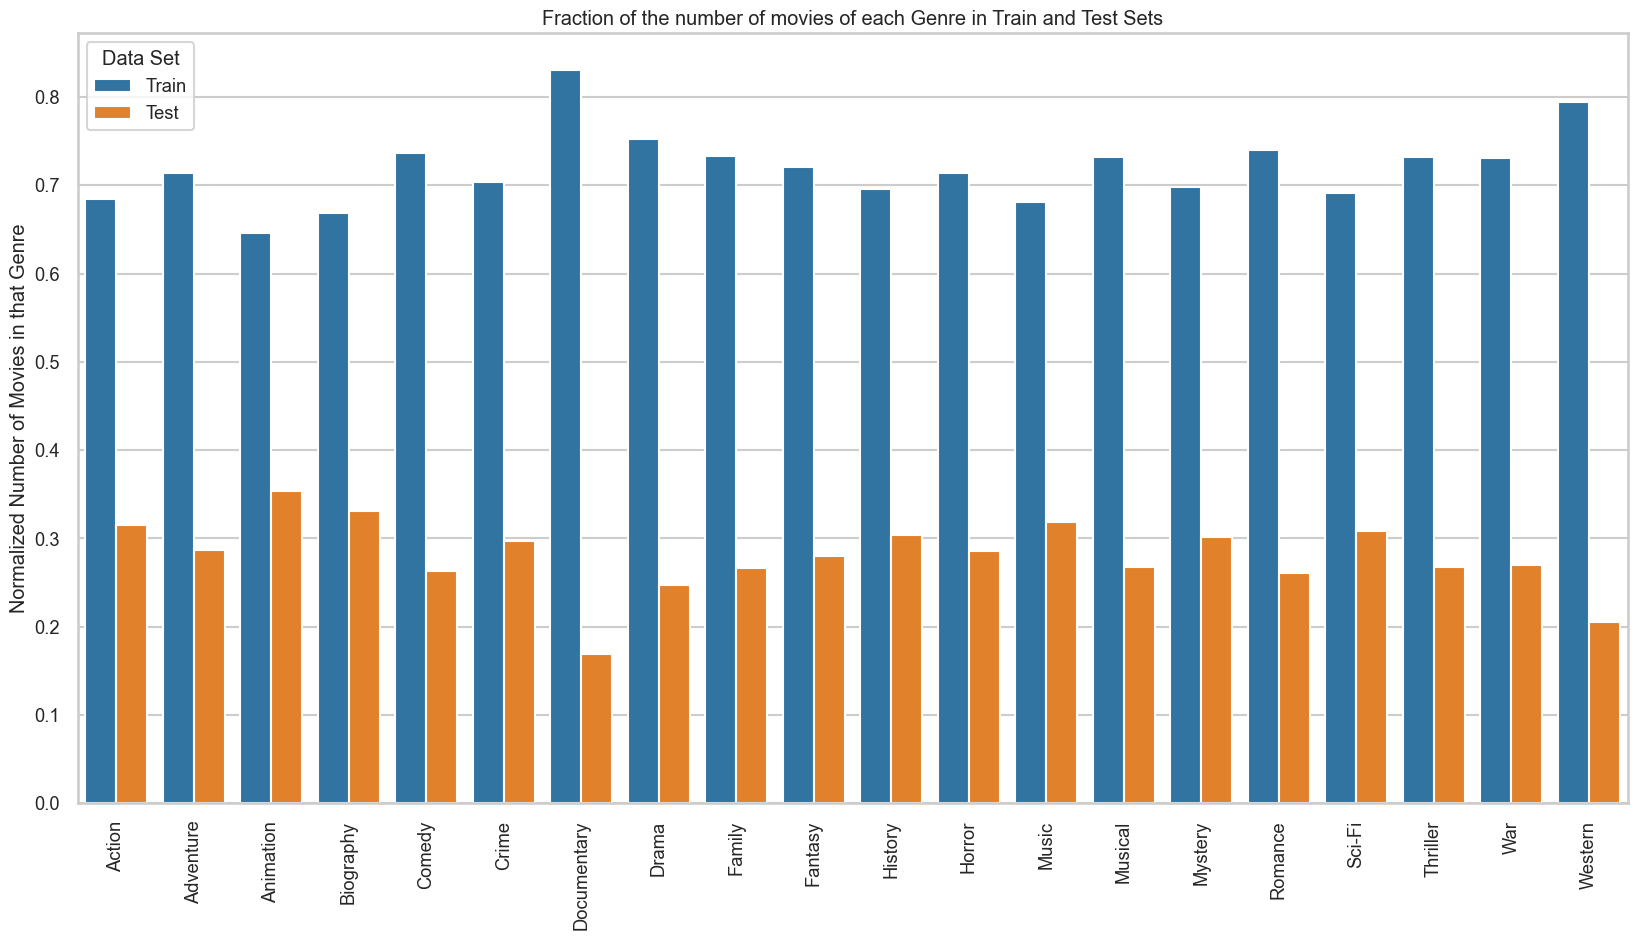

In [57]:
f, ax = plt.subplots(1, 1, figsize=(20, 10))
sns.barplot(data=df_movies_per_genre, x='Genre', y='Total', hue='Data Set', axes=ax)
ax.set(ylabel='Normalized Number of Movies in that Genre', xlabel='')
ax.set(title='Fraction of the number of movies of each Genre in Train and Test Sets')
plt.xticks(rotation=90)
plt.show()

In [58]:
## do same thing for grouped genders
min_test_size = 0.120
mydatagrouped_train, mydatagrouped_test = multi_label_train_test_split(dfGroupedGenders, category_columns_grouped, test_size=min_test_size)

In [59]:
print('Fraction of data in the Training Data Set: {0:.3f}'.format(mydatagrouped_test.shape[0]/dfGroupedGenders.shape[0]))

Fraction of data in the Training Data Set: 0.225


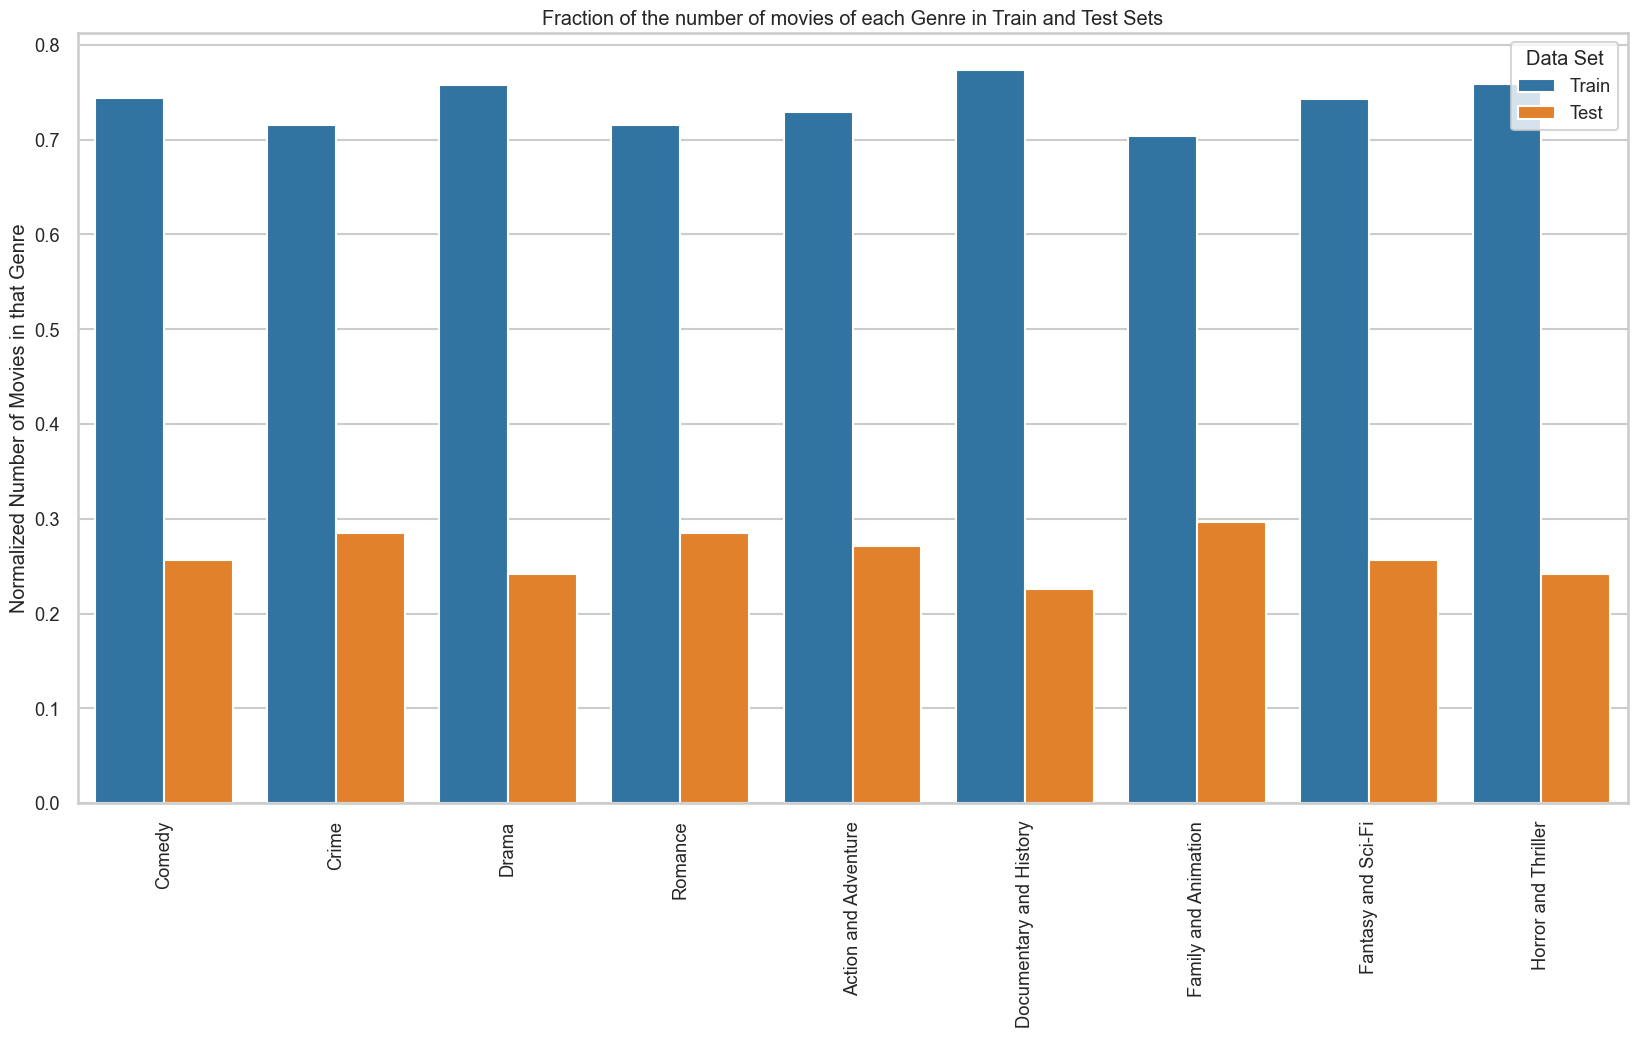

In [60]:
sum_genre = dfGroupedGenders[category_columns_grouped].sum()
sum_genre_train = mydatagrouped_train[category_columns_grouped].sum()
sum_genre_test = mydatagrouped_test[category_columns_grouped].sum()
df_movies_per_genre_1 = pd.DataFrame({'Genre':category_columns_grouped, 'Total': sum_genre_train/sum_genre, 'Data Set': 'Train'})
df_movies_per_genre_2 = pd.DataFrame({'Genre':category_columns_grouped, 'Total': sum_genre_test/sum_genre, 'Data Set': 'Test'})
df_movies_per_genre = pd.concat([df_movies_per_genre_1, df_movies_per_genre_2])
f, ax = plt.subplots(1, 1, figsize=(20, 10))
sns.barplot(data=df_movies_per_genre, x='Genre', y='Total', hue='Data Set', axes=ax)
ax.set(ylabel='Normalized Number of Movies in that Genre', xlabel='')
ax.set(title='Fraction of the number of movies of each Genre in Train and Test Sets')
plt.xticks(rotation=90)
plt.show()

In [61]:
mydata_train.to_csv('../data/preprocessed/movies_genres_train_preprocessed.csv', index=False)
mydata_test.to_csv('../data/preprocessed/movies_genres_test_preprocessed.csv', index=False)

In [62]:
mydatagrouped_train.to_csv('../data/preprocessed/movies_genres_grouped_train_preprocessed.csv', index=False)
mydatagrouped_test.to_csv('../data/preprocessed/movies_genres_grouped_test_preprocessed.csv', index=False)